# Sentiment Analysis

<a id="0"></a>
#### Contents:
* [1. Dataset](#1)
    * [1.1. Loading Data](#1.1)
    * [1.2. Data Preprocessing](#1.2)
    * [1.3. Dataset Visualization](#1.3)
* [2. Classifiers](#2)
    * [2.1. Naive Bayes Classfication](#2.1)
    * [2.2. K-Nearest Neighbour Classification](#2.2)
    * [2.3. Support Vector Machine (SVM) Classification](#2.3)
    * [2.4. Decision Tree Machine Classification](#2.3)
* [Advanced. Emotions in data](#advanced)

In [153]:
# !pip install langdetect
# !pip install regex
# !pip install tqdm
# !pip install nltk
# !pip install imblearn
# !pip install tensorflow
# !pip install transformers
# !pip install wordcloud
# !pip install jinja2

In [154]:
# Import libraries
import ast
import pandas as pd
import numpy as np
import regex as re
import string
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
from tqdm import tqdm
tqdm.pandas()

# preprocessing 
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from langdetect import DetectorFactory
from imblearn.under_sampling import RandomUnderSampler

# word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None


from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Below are for Bert 

# transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

# keras
import tensorflow as tf
from tensorflow import keras

# set seed for reproducibility
seed=42

<a id="1"></a>
[<font size="+2" ><b>1. Dataset Presentation</b></font><br>](#0)

It is wise to explore our dataset first

<a id="1.1"></a>
[<font size="+1" ><b>1.1. Loading Data</b></font><br>](#0)
Load necessary data.

In [155]:
# Removing unused columns
df_outside = pd.read_csv('dataset_transformed.csv', encoding='latin')
df_crawl = pd.read_csv('compiled_tweets.csv')

# df_outside = pd.read_csv("/dbfs/FileStore/shared_uploads/dataset_transformed.csv", encoding='latin')
# df_crawl = pd.read_csv("/dbfs/FileStore/shared_uploads/compiled_tweets.csv", encoding='latin')
df_outside = df_outside[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[df_crawl['Subjectivity'].notna()].copy()
df = pd.concat([df_crawl, df_outside]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13508 entries, 0 to 13507
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Text          13508 non-null  object 
 1   Subjectivity  11343 non-null  float64
 2   Polarity      7788 non-null   float64
dtypes: float64(2), object(1)
memory usage: 316.7+ KB


<a id="1.2"></a>
[<font size="+1" ><b>1.2. Data Preprocessing</b></font><br>](#0)

As twitter texts are relatively unclean compared with others, special cleaning are applied to remove emojis and links

In [156]:
# set seed
DetectorFactory.seed = 0

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang

In [157]:
df['Language'] = df['Text'].progress_apply(language_detection)

100%|██████████| 13508/13508 [00:45<00:00, 295.59it/s]


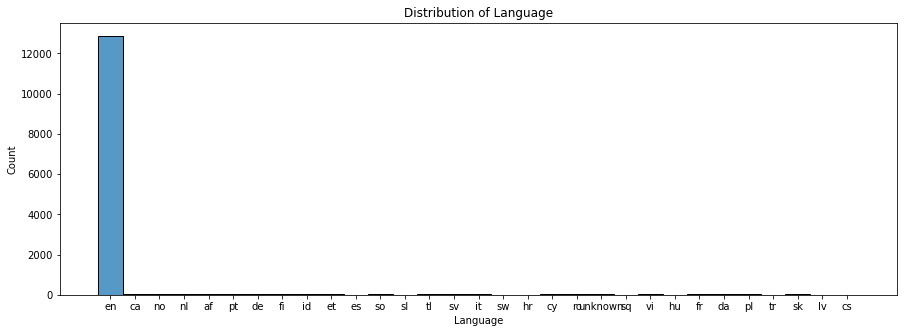

In [158]:
#plot the distribution of language
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=df['Language'])
plt.title("Distribution of Language")
plt.show()

In [159]:
df = df[df['Language'] == 'en'].copy()

In [160]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    # text = re.sub(r'pic.twitter\S+', ' ', text)
    text = re.sub(r'#', '', text)
    text = text.lower()

    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)

    return text


def remove_punc(tweet):
    tweet =  tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = ' '.join([word for word in tweet.split()])
    tweet = tweet.lower()
    
    return tweet

In [161]:
df['Text'] = df['Text'].progress_apply(clean_text).apply(decontracted).apply(remove_punc)
df.head()

100%|██████████| 12868/12868 [00:00<00:00, 29988.56it/s]


,Text,Subjectivity,Polarity,Language
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en


### Stemming

In [162]:
nltk.download('punkt')
nltk.download('stopwords')

def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

df['stemmed_text'] = df['Text'].progress_apply(stem_text)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ychen21\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ychen21\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 12868/12868 [00:05<00:00, 2434.21it/s]


,Text,Subjectivity,Polarity,Language,stemmed_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew i just went live on twitch come...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,littl bit of dbd into apex legend t co fihcgni...
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex let get some damag t co dbt...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgam go crazi on apex follow up c...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hop into some apexlegend for a bit come o...


### Lemmatization

In [163]:
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatize_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in tweet.split()]) for tweet in corpus]

df['lemmatized_text'] = lemmatize_text(df['Text'])
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ychen21\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ychen21\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Text,Subjectivity,Polarity,Language,stemmed_text,lemmatized_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew i just went live on twitch come...,hey kingz crew i just went live on twitch come...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,littl bit of dbd into apex legend t co fihcgni...,little bit of dbd into apex legend t co fihcgn...
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex let get some damag t co dbt...,tuesday night apex let get some damage t co db...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgam go crazi on apex follow up c...,watch tohrmentgames go crazy on apex follow up...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hop into some apexlegend for a bit come o...,live hopping into some apexlegends for a bit c...


### Stopwords Removal

In [164]:
stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d", 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb']
stop = set(stop + additional_stopwords)

def remove_stopwords(x):
    x = word_tokenize(x)
    store_words = ''
    
    for i in x:
        if i not in stop:
            store_words += i + ' '
            
    return store_words

In [165]:
df['cleaned_text'] = df['Text'].progress_apply(remove_stopwords)
df['cleaned_stemmed_text'] = df['stemmed_text'].progress_apply(remove_stopwords)
df['cleaned_lemmatized_text'] = df['lemmatized_text'].progress_apply(remove_stopwords)

df.head()

100%|██████████| 12868/12868 [00:01<00:00, 9970.51it/s] 


,Text,Subjectivity,Polarity,Language,stemmed_text,lemmatized_text,cleaned_text,cleaned_stemmed_text,cleaned_lemmatized_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew i just went live on twitch come...,hey kingz crew i just went live on twitch come...,hey kingz crew went live twitch come chat hang...,hey kingz crew went live twitch come chat hang...,hey kingz crew went live twitch come chat hang...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,littl bit of dbd into apex legend t co fihcgni...,little bit of dbd into apex legend t co fihcgn...,little bit dbd apex legends co fihcgnia,littl bit dbd apex legend co fihcgnia,little bit dbd apex legend co fihcgnia
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex let get some damag t co dbt...,tuesday night apex let get some damage t co db...,tuesday night apex lets get damage co dbt givs...,tuesday night apex let get damag co dbt givsyr...,tuesday night apex let get damage co dbt givsy...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgam go crazi on apex follow up c...,watch tohrmentgames go crazy on apex follow up...,watch tohrmentgames go crazy apex follow carbo...,watch tohrmentgam go crazi apex follow carbong...,watch tohrmentgames go crazy apex follow carbo...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hop into some apexlegend for a bit come o...,live hopping into some apexlegends for a bit c...,live hopping apexlegends bit come want witness...,live hop apexlegend bit come want wit decent g...,live hopping apexlegends bit come want witness...


<a id="1.3"></a>
[<font size="+1"><b>1.3. Data Visualization</b></font><br>](#0)

In [166]:
print("========== number of words in the corpus ==========")

print(f"original: {df['Text'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming: {df['stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after lemmatization: {df['lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after removal of stopwords: {df['cleaned_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming and removal of stopwords: {df['cleaned_stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after lemmatization and removal of stopwords: {df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

========== number of words in the corpus ==========
original: 326258
after stemming: 326653
after lemmatization: 326258
after removal of stopwords: 187578
after stemming and removal of stopwords: 195758
after lemmatization and removal of stopwords: 188188


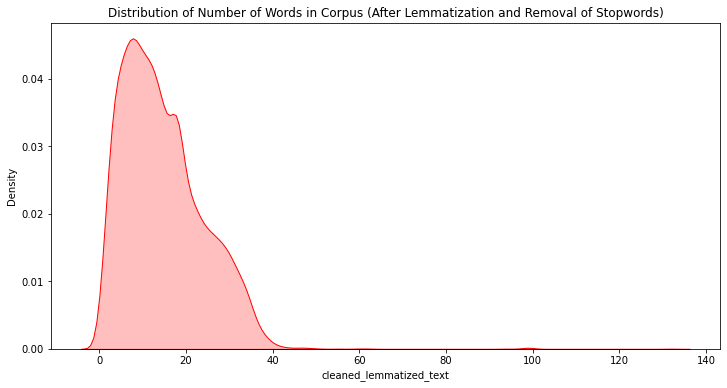

In [167]:
num_words_train = df['cleaned_lemmatized_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())), fill=True, color="r").set_title('Distribution of Number of Words in Corpus (After Lemmatization and Removal of Stopwords)')

In [168]:
word_list_train = df.cleaned_lemmatized_text.str.split()
top = Counter([item for sublist in word_list_train for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,2640
1,com,1973
2,wa,1170
3,like,1143
4,really,991
5,pic,942
6,get,931
7,one,925
8,time,890
9,co,883


In [169]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = seed,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

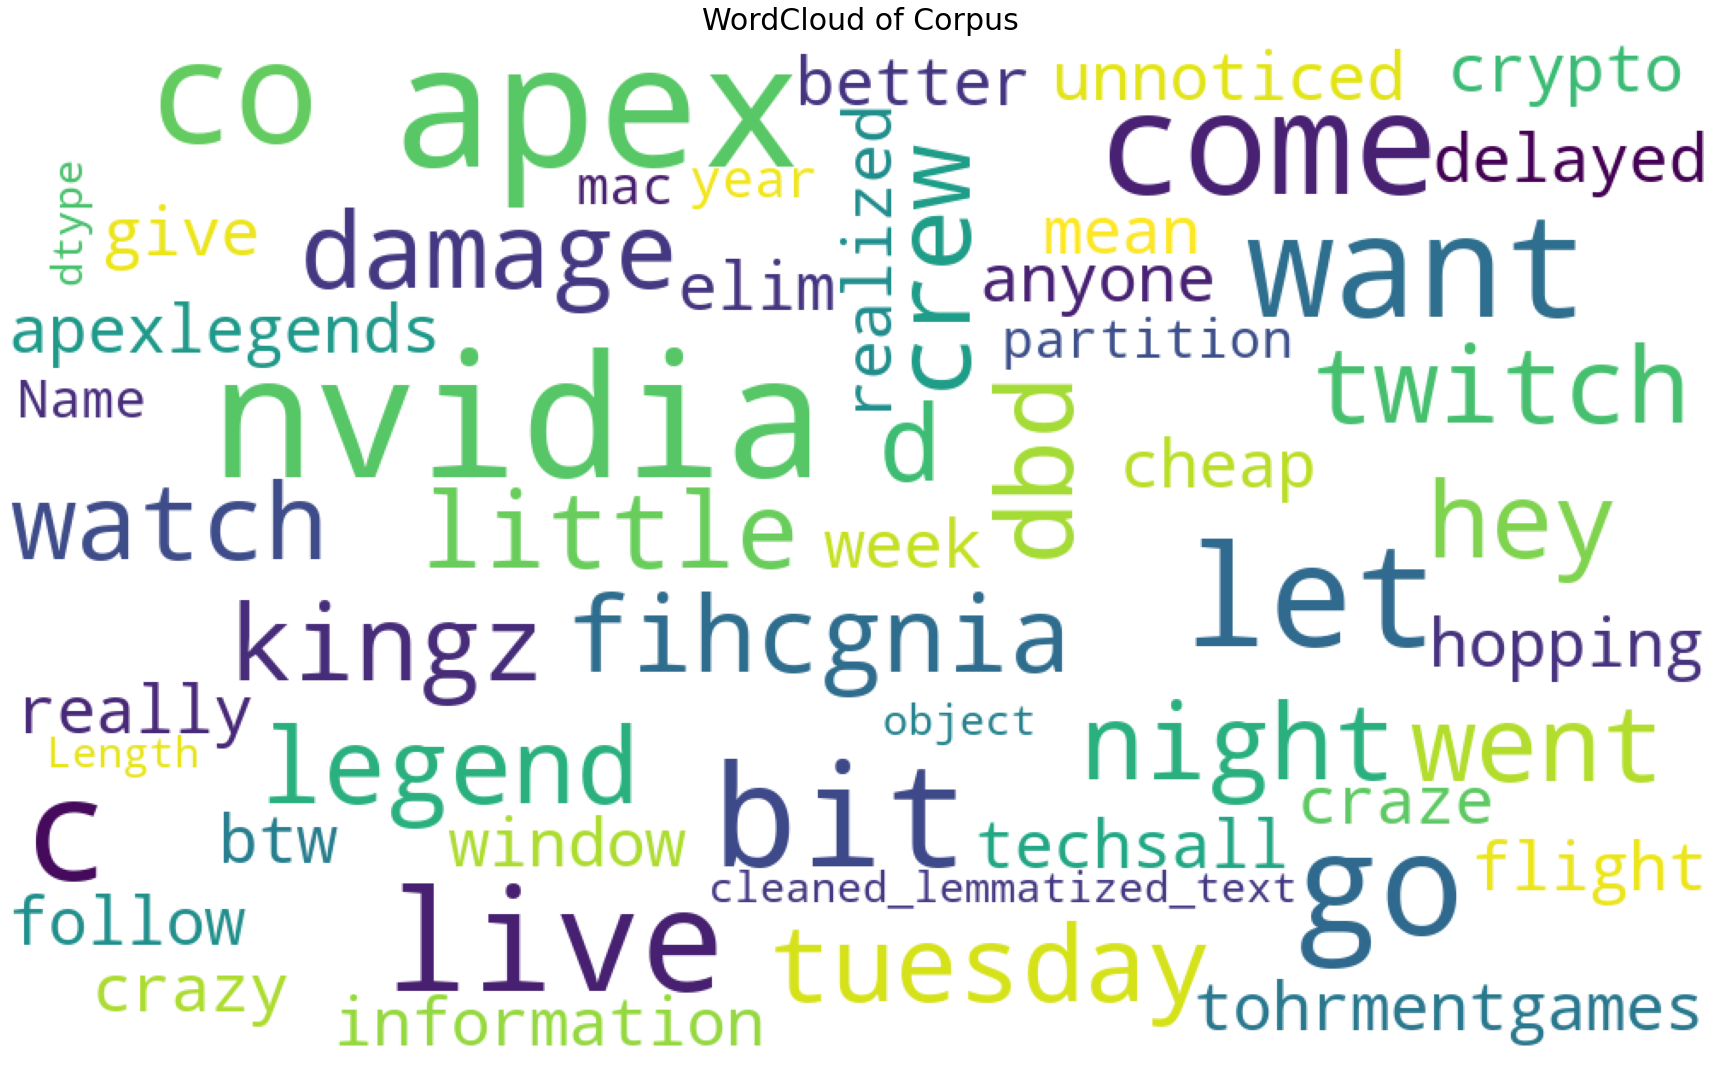

In [170]:
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list_train, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Corpus")

<a id="2"></a>
[<font size="+2" ><b>2. Classifiers</b></font><br>](#0)

<a id="2.1"></a>
[<font size="+1" ><b>2.1. Naive Bayes Classification</b></font><br>](#0)

In [171]:
def naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing):

    naiveBayes_model = MultinomialNB().fit(x_train, y_train)
    result = naiveBayes_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Naive Bayes Classification")
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Naive Bayes Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

<a id="2.2"></a>
[<font size="+1" ><b>2.2. K-Nearest Neighbour (KNN) Classification</b></font><br>](#0)

In [172]:
def KNNClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):

    if best_params is None:
        
        print("Searching for best parameters")

        metric = ['euclidean', 'manhattan', 'cosine']
        neighbors = list(range(1,30))
        leaf_size = list(range(1,50))
        weight = ['uniform', 'distance']
        param_grid = {'metric' : metric, 'n_neighbors': neighbors, 'weights' : weight, 'leaf_size' : leaf_size}
        
        grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_
    
    
    knn_model = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], metric= best_params['metric'], leaf_size = best_params['leaf_size'], weights = best_params['weights'])
    knn_model.fit(x_train, y_train)   
    
    result = knn_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: K-Nearest Neighbour Classification")
    print("Best parameters:", best_params)
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of KNN Classification of tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()
  

<a id="2.3"></a>
[<font size="+1" ><b>2.3. Support Vector Machine (SVM) Classification</b></font><br>](#0)

In [173]:
def SVMClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):

    if best_params is None:
        
        print("Searching for best parameters")

        Cs = [0.001, 0.01, 0.1, 1, 10]
        gammas = [0.05, 0.1, 0.15, 0.20, 0.25]
        degrees = [0, 1, 2, 3, 4, 5, 6]
        kernels = ['rbf', 'linear', 'poly']
        param_grid = {'C': Cs, 'gamma' : gammas, 'degree' : degrees, 'kernel' : kernels}
        
        grid_search = GridSearchCV(svm.SVC(), param_grid, cv = 3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_

    SVM_model = svm.SVC(C = best_params['C'], kernel = best_params['kernel'], gamma = best_params['gamma'], degree = best_params['degree'], random_state=seed)
    SVM_model.fit(x_train, y_train)
    
    result = SVM_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Support Vector Machine Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of SVM Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

<a id="2.4"></a>
[<font size="+1" ><b>2.4. Decision Tree Classification</b></font><br>](#0)

In [174]:
def decisionTreeClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):
    
    clf = DecisionTreeClassifier() 

    if best_params is None:
            
        print("Searching for best parameters")
        param_grid = { 
            'criterion': ['gini','entropy'],
            'splitter': ['best','random'],
            'max_features': ['sqrt','log2']
        }
        
        grid_search = GridSearchCV(clf, param_grid, cv= 3)
        grid_search.fit(x_valid, y_valid)
        best_params = grid_search.best_params_

    decisionTree_model = DecisionTreeClassifier(criterion = best_params['criterion'],splitter = best_params['splitter'], max_features = best_params['max_features'], random_state=seed)
    decisionTree_model.fit(x_train, y_train)

    result = decisionTree_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)


    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Decision Tree Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Decision Tree Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

<a id="3"></a>
[<font size="+2" ><b>3. Training</b></font><br>](#0)

In [175]:
# don't consider uncleaned text for now (too much noise)
preprocessings = ['cleaned_stemmed_text', 'cleaned_lemmatized_text', 'cleaned_text'] 

<a id="3"></a>
[<font size="+1" ><b>3.1. Vectorization</b></font><br>](#0)

In [176]:
df = df[df['Subjectivity'].notna()].copy()
df['Subjectivity'].value_counts()

1.0    7387
0.0    3401
Name: Subjectivity, dtype: int64

We can see that here the class is highly unbalanced with too many biased content. For better output, we need to balance the dataset first

In [177]:
#  Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.
sampler = RandomUnderSampler(random_state=seed)
X_sub, Y_sub = sampler.fit_resample(df[preprocessings], df['Subjectivity'])
Y_sub.value_counts()

0.0    3401
1.0    3401
Name: Subjectivity, dtype: int64

In [178]:
# do the same for 'Polarity'
polar_df = df[df['Polarity'].notna()].copy()
polar_df['Polarity'].value_counts()

0.0    3847
1.0    3534
Name: Polarity, dtype: int64

In [179]:
X_polar, Y_polar = sampler.fit_resample(polar_df[preprocessings], polar_df['Polarity'])
Y_polar.value_counts()

0.0    3534
1.0    3534
Name: Polarity, dtype: int64

<b> Train, test, cv split </b>

In [180]:
# for subjectivity, get train set, valid set (cross validation), andn test set
X_train_valid_sub, X_test_sub, y_train_valid_sub, y_test_sub = train_test_split(X_sub, 
                                                    Y_sub,
                                                    test_size = 0.3, 
                                                    random_state = seed, stratify=Y_sub)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_valid_sub, 
                                                    y_train_valid_sub,
                                                    test_size = 0.1, 
                                                    random_state = seed, stratify=y_train_valid_sub)

print(f"Shape of X_train: {X_train_sub.shape}")
print(f"Shape of y_train: {y_train_sub.shape}")
print(f"Shape of X_valid: {X_valid_sub.shape}")
print(f"Shape of y_valid: {y_valid_sub.shape}")
print(f"Shape of X_test: {X_test_sub.shape}")
print(f"Shape of y_test: {y_test_sub.shape}")

Shape of X_train: (4284, 3)
Shape of y_train: (4284,)
Shape of X_valid: (477, 3)
Shape of y_valid: (477,)
Shape of X_test: (2041, 3)
Shape of y_test: (2041,)


In [181]:
# for polarity, get train set, valid set (cross validation), andn test set
X_train_valid_polar, X_test_polar, y_train_valid_polar, y_test_polar = train_test_split(X_polar, 
                                                    Y_polar,
                                                    test_size = 0.3, 
                                                    random_state = seed, stratify=Y_polar)
X_train_polar, X_valid_polar, y_train_polar, y_valid_polar = train_test_split(X_train_valid_polar, 
                                                    y_train_valid_polar,
                                                    test_size = 0.1, 
                                                    random_state = seed, stratify=y_train_valid_polar)

print(f"Shape of X_train: {X_train_polar.shape}")
print(f"Shape of y_train: {y_train_polar.shape}")
print(f"Shape of X_valid: {X_valid_polar.shape}")
print(f"Shape of y_valid: {y_valid_polar.shape}")
print(f"Shape of X_test: {X_test_polar.shape}")
print(f"Shape of y_test: {y_test_polar.shape}")

Shape of X_train: (4452, 3)
Shape of y_train: (4452,)
Shape of X_valid: (495, 3)
Shape of y_valid: (495,)
Shape of X_test: (2121, 3)
Shape of y_test: (2121,)


In [182]:
vec_X_train_sub = {}
vec_X_valid_sub = {}
vec_X_test_sub = {}
# The CountVectorizer will select the words/features/terms which occur the most frequently. It takes absolute values so if you set the 'max_features = 3', it will select the 3 most common words in the data.
for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=500).fit(X_train_sub[method])
    X_train_cv =  clf.transform(X_train_sub[method])
    X_valid_cv = clf.transform(X_valid_sub[method])
    X_test_cv = clf.transform(X_test_sub[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_sub[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_sub[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_sub[method] = tf_transformer.transform(X_test_cv)

In [183]:
vec_X_train_polar = {}
vec_X_valid_polar = {}
vec_X_test_polar = {}

for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=500).fit(X_train_polar[method])
    X_train_cv =  clf.transform(X_train_polar[method])
    X_valid_cv = clf.transform(X_valid_polar[method])
    X_test_cv = clf.transform(X_test_polar[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_polar[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_polar[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_polar[method] = tf_transformer.transform(X_test_cv)

<a id="3.2"></a>
[<font size="+1" ><b>3.2. Subjectivity Classification & Evaluation </b></font><br>](#0)

We use naive bayes model's performance as the baseline for measurements of other models.

In [184]:
best_params_df = pd.read_csv("Best_Params.csv")
best_params_df

,model,task,input,best_params
0,KNN,subjectivity,cleaned_stemmed_text,"{'leaf_size': 1, 'metric': 'euclidean', 'n_nei..."
1,SVM,subjectivity,cleaned_stemmed_text,"{'C': 10, 'degree': 0, 'gamma': 0.05, 'kernel'..."
2,DecisionTree,subjectivity,cleaned_stemmed_text,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
3,KNN,subjectivity,cleaned_lemmatized_text,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighb..."
4,SVM,subjectivity,cleaned_lemmatized_text,"{'C': 1, 'degree': 1, 'gamma': 0.25, 'kernel':..."
5,DecisionTree,subjectivity,cleaned_lemmatized_text,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
6,KNN,subjectivity,cleaned_text,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighb..."
7,SVM,subjectivity,cleaned_text,"{'C': 1, 'degree': 0, 'gamma': 0.2, 'kernel': ..."
8,DecisionTree,subjectivity,cleaned_text,"{'criterion': 'entropy', 'max_features': 'sqrt..."
9,KNN,polarity,cleaned_stemmed_text,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighb..."


In [185]:
def get_best_params(model_name: str, task: str, src:str):
    param = best_params_df[(best_params_df['model'] == model_name) & (best_params_df['task']==task) & (best_params_df['input'] == src)]['best_params'].values[0]
    try:
        return ast.literal_eval(param)
    except:
        return None

In [186]:
def base_line_performance(processing_idx:int, task: str):
    print("Base line")
    method = preprocessings[processing_idx]
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_test = y_test_polar
        
    naiveBayesClassification(x_train, x_test, y_train, y_test, method)

In [187]:
def classifier_performance(processing_idx:int, task: str):
    method = preprocessings[processing_idx]
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_valid = vec_X_valid_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_valid = y_valid_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_valid = vec_X_valid_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_valid = y_valid_polar
        y_test = y_test_polar

    decisionTreeClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('DecisionTree', task, method))

    SVMClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('SVM', task, method)
    )

    KNNClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('KNN', task, method)
    )

<b> 3.2.1 Subjectivity with Cleaned Stemmed Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_stemmed_text



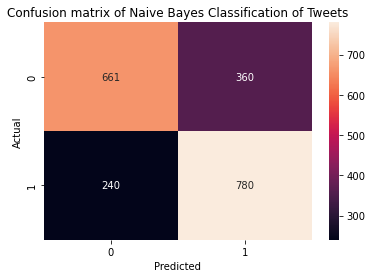

------------ Evaluation Metrics ----------------

F1 score: 0.722
Precision score: 0.684
Recall score: 0.765
Average precision-recall score: 0.641



In [188]:
base_line_performance(0,'subjectivity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'random'}



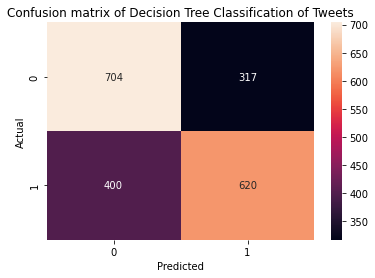

------------ Evaluation Metrics ----------------

F1 score: 0.634
Precision score: 0.662
Recall score: 0.608
Average precision-recall score: 0.598

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'C': 10, 'degree': 0, 'gamma': 0.05, 'kernel': 'rbf'}



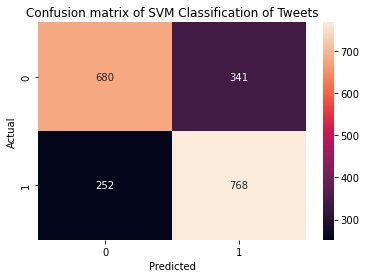

------------ Evaluation Metrics ----------------

F1 score: 0.721
Precision score: 0.693
Recall score: 0.753
Average precision-recall score: 0.645

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 22, 'weights': 'uniform'}
Preprocessing Function:  cleaned_stemmed_text



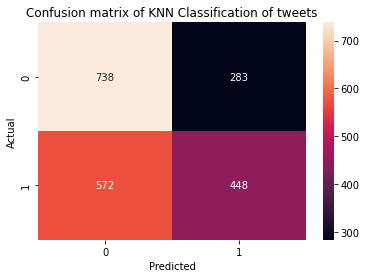

------------ Evaluation Metrics ----------------

F1 score: 0.512
Precision score: 0.613
Recall score: 0.439
Average precision-recall score: 0.549



In [189]:
classifier_performance(0,'subjectivity')

<b> 3.2.2 Subjectivity with Cleaned Lemmatized Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_lemmatized_text



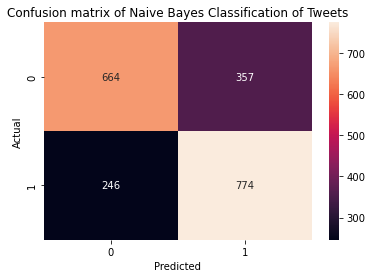

------------ Evaluation Metrics ----------------

F1 score: 0.720
Precision score: 0.684
Recall score: 0.759
Average precision-recall score: 0.640



In [190]:
base_line_performance(1,'subjectivity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'random'}



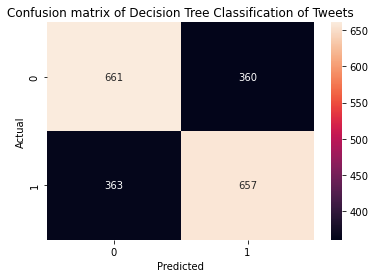

------------ Evaluation Metrics ----------------

F1 score: 0.645
Precision score: 0.646
Recall score: 0.644
Average precision-recall score: 0.594

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'C': 1, 'degree': 1, 'gamma': 0.25, 'kernel': 'poly'}



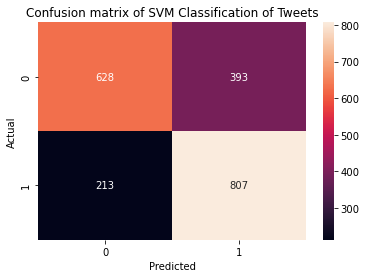

------------ Evaluation Metrics ----------------

F1 score: 0.727
Precision score: 0.672
Recall score: 0.791
Average precision-recall score: 0.636

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 28, 'weights': 'distance'}
Preprocessing Function:  cleaned_lemmatized_text



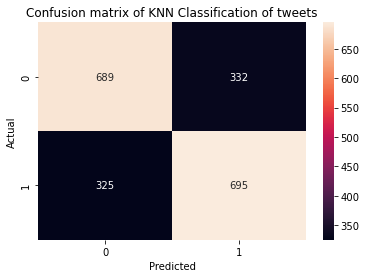

------------ Evaluation Metrics ----------------

F1 score: 0.679
Precision score: 0.677
Recall score: 0.681
Average precision-recall score: 0.620



In [191]:
classifier_performance(1,'subjectivity')

<b> 3.2.3 Subjectivity with Cleaned Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_text



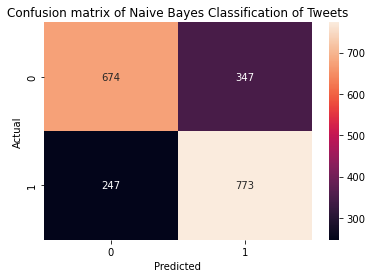

------------ Evaluation Metrics ----------------

F1 score: 0.722
Precision score: 0.690
Recall score: 0.758
Average precision-recall score: 0.644



In [192]:
base_line_performance(2, 'subjectivity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}



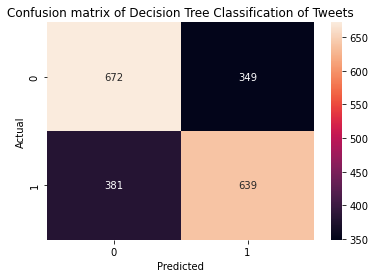

------------ Evaluation Metrics ----------------

F1 score: 0.636
Precision score: 0.647
Recall score: 0.626
Average precision-recall score: 0.592

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.2, 'kernel': 'rbf'}



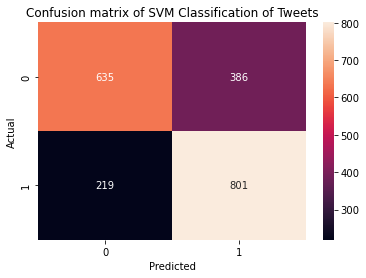

------------ Evaluation Metrics ----------------

F1 score: 0.726
Precision score: 0.675
Recall score: 0.785
Average precision-recall score: 0.637

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 24, 'weights': 'distance'}
Preprocessing Function:  cleaned_text



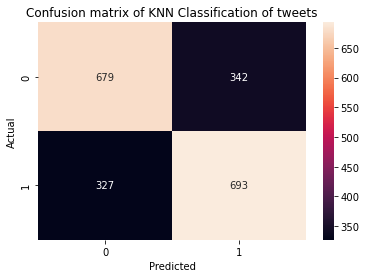

------------ Evaluation Metrics ----------------

F1 score: 0.674
Precision score: 0.670
Recall score: 0.679
Average precision-recall score: 0.615



In [193]:
classifier_performance(2, 'subjectivity')

<a id="3.3"></a>
[<font size="+1" ><b>3.3. Polarity Classification & Evaluation </b></font><br>](#0)

We use naive bayes model's performance as the baseline for measurements of other models.

<b> 3.3.1 Polarity with Cleaned Stemmed Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_stemmed_text



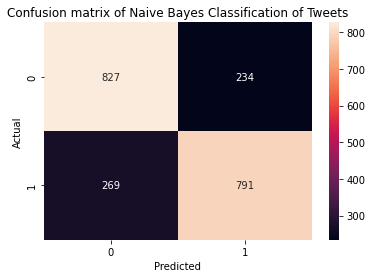

------------ Evaluation Metrics ----------------

F1 score: 0.759
Precision score: 0.772
Recall score: 0.746
Average precision-recall score: 0.703



In [194]:
base_line_performance(0,'polarity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}



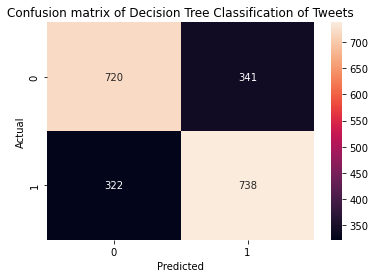

------------ Evaluation Metrics ----------------

F1 score: 0.690
Precision score: 0.684
Recall score: 0.696
Average precision-recall score: 0.628

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.2, 'kernel': 'rbf'}



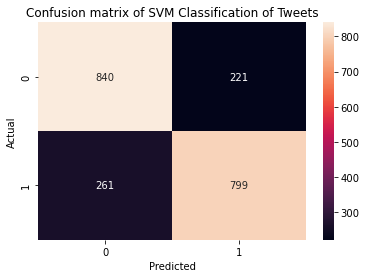

------------ Evaluation Metrics ----------------

F1 score: 0.768
Precision score: 0.783
Recall score: 0.754
Average precision-recall score: 0.714

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 27, 'weights': 'distance'}
Preprocessing Function:  cleaned_stemmed_text



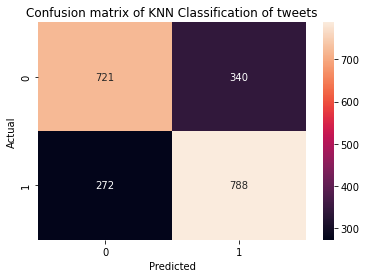

------------ Evaluation Metrics ----------------

F1 score: 0.720
Precision score: 0.699
Recall score: 0.743
Average precision-recall score: 0.648



In [195]:
classifier_performance(0,'polarity')

<b> 3.3.2 Polarity with Cleaned Lemmatized Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_lemmatized_text



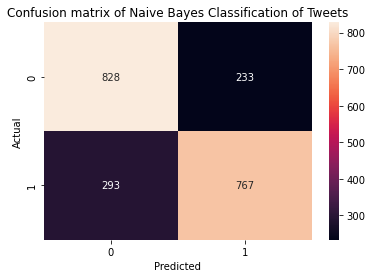

------------ Evaluation Metrics ----------------

F1 score: 0.745
Precision score: 0.767
Recall score: 0.724
Average precision-recall score: 0.693



In [196]:
base_line_performance(1,'polarity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'best'}



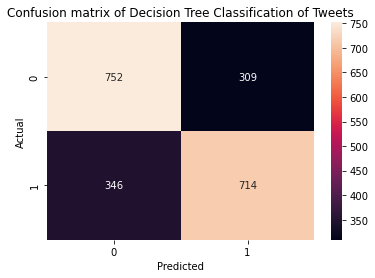

------------ Evaluation Metrics ----------------

F1 score: 0.686
Precision score: 0.698
Recall score: 0.674
Average precision-recall score: 0.633

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'C': 1, 'degree': 1, 'gamma': 0.25, 'kernel': 'poly'}



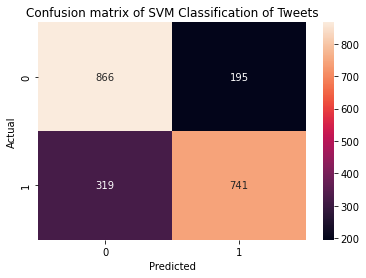

------------ Evaluation Metrics ----------------

F1 score: 0.742
Precision score: 0.792
Recall score: 0.699
Average precision-recall score: 0.704

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 19, 'weights': 'distance'}
Preprocessing Function:  cleaned_lemmatized_text



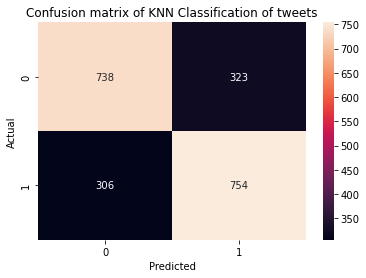

------------ Evaluation Metrics ----------------

F1 score: 0.706
Precision score: 0.700
Recall score: 0.711
Average precision-recall score: 0.642



In [197]:
classifier_performance(1,'polarity')

<b> 3.3.3 Polarity with Cleaned Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_text



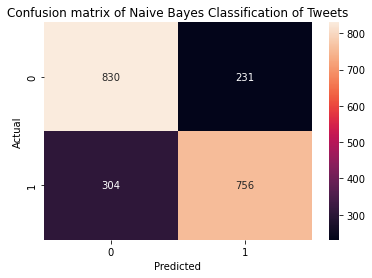

------------ Evaluation Metrics ----------------

F1 score: 0.739
Precision score: 0.766
Recall score: 0.713
Average precision-recall score: 0.690



In [198]:
base_line_performance(2, 'polarity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}



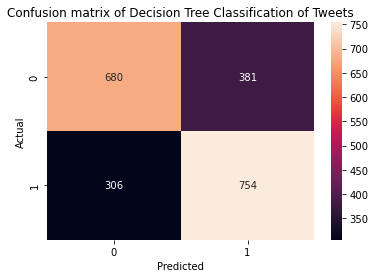

------------ Evaluation Metrics ----------------

F1 score: 0.687
Precision score: 0.664
Recall score: 0.711
Average precision-recall score: 0.617

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.25, 'kernel': 'rbf'}



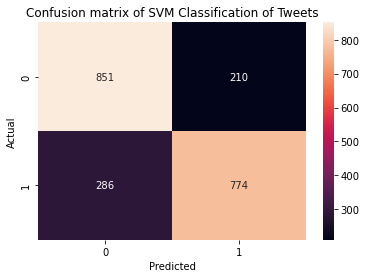

------------ Evaluation Metrics ----------------

F1 score: 0.757
Precision score: 0.787
Recall score: 0.730
Average precision-recall score: 0.709

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 18, 'weights': 'uniform'}
Preprocessing Function:  cleaned_text



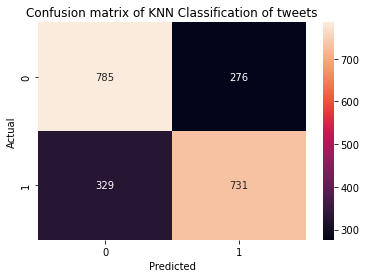

------------ Evaluation Metrics ----------------

F1 score: 0.707
Precision score: 0.726
Recall score: 0.690
Average precision-recall score: 0.656



In [199]:
classifier_performance(2, 'polarity')

<a id="3"></a>
[<font size="+2" ><b>Innovation1: Traditionoal Classifiers vs Bert</b></font><br>](#0)

In [200]:
MAX_LEN=150

warnings.filterwarnings(action='ignore')    # to suppress future warnings etc

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            text=data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [201]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(1, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    return model

In [202]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(5,5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [203]:
checkpoint_path_sub = "training_sub/cp.ckpt"
checkpoint_dir_sub = os.path.dirname(checkpoint_path_sub)
checkpoint_path_polar = "training_polar/cp.ckpt"
checkpoint_dir_polar = os.path.dirname(checkpoint_path_polar)

<a id="3.1"></a>
[<font size="+1" ><b>Subjectivity</b></font><br>](#0)

In [ ]:
train_input_ids, train_attention_masks = tokenize(list(X_train_sub['cleaned_text']), MAX_LEN)
val_input_ids, val_attention_masks = tokenize(list(X_valid_sub['cleaned_text']), MAX_LEN)
test_input_ids, test_attention_masks = tokenize(list(X_test_sub['cleaned_text']), MAX_LEN)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

In [ ]:
# use raw_model to predict and see the model's performance before training
y_pred_before_train = model.predict([test_input_ids,test_attention_masks])

In [ ]:
conf_matrix(y_test_sub, y_pred_before_train,'BERT Subjectivity Analysis\nConfusion Matrix\nBefore Training', ['Subjective', 'Opinionated'])

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_sub,y_pred_before_train, target_names=['Subjective', 'Opinionated']))

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Loads the weights or train
try:
    model.load_weights(checkpoint_path_sub)
except:
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_sub,
                                                    save_weights_only=True,
                                                    verbose=1)
    model.fit([train_input_ids,train_attention_masks], y_train_sub, validation_data=([val_input_ids,val_attention_masks], y_valid_sub), epochs=4, batch_size=32, callbacks=[cp_callback])  # Pass callback to training

In [ ]:
y_pred_bert = model.predict([test_input_ids,test_attention_masks])

In [ ]:
conf_matrix(y_test_sub, y_pred_bert,'BERT Subjectivity Analysis\nConfusion Matrix', ['Subjective', 'Opinionated'])

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_sub,y_pred_bert, target_names=['Subjective', 'Opinionated']))

<a id="3.1"></a>
[<font size="+1" ><b>Polarity</b></font><br>](#0)

In [204]:
polar_train_input_ids, polar_train_attention_masks = tokenize(list(X_train_polar['cleaned_text']), MAX_LEN)
polar_val_input_ids, polar_val_attention_masks = tokenize(list(X_valid_polar['cleaned_text']), MAX_LEN)
polar_test_input_ids, polar_test_attention_masks = tokenize(list(X_test_polar['cleaned_text']), MAX_LEN)

In [205]:
polar_train_input_ids.shape

(4452, 150)

In [206]:
polar_val_input_ids.shape

(495, 150)

In [207]:
polar_test_input_ids.shape

(2121, 150)

In [208]:
polar_bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [209]:
polar_model = create_model(polar_bert_model, MAX_LEN)
polar_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 150,                                         

In [210]:
# use raw_model to predict and see the model's performance before training
y_pred_before_train_polar = model.predict([polar_test_input_ids,polar_test_attention_masks])

 4/67 [>.............................] - ETA: 8:28

In [ ]:
conf_matrix(y_test_polar, y_pred_before_train_polar,'BERT Polarity Analysis\nConfusion Matrix\nBefore Training', ['Negative', 'Positive'])

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_polar, y_pred_before_train_polar, target_names=['Negative', 'Positive']))

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Loads the weights or train
try:
    polar_model.load_weights(checkpoint_path_polar)
except:
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_polar,
                                                    save_weights_only=True,
                                                    verbose=1)
    polar_model.fit(
        [polar_train_input_ids,polar_train_attention_masks], 
        y_train_polar, 
        validation_data=([polar_val_input_ids,polar_val_attention_masks], y_valid_polar), 
        epochs=4, batch_size=32, callbacks=[cp_callback])  # Pass callback to training

In [ ]:
y_pred_polar = polar_model.predict([polar_test_input_ids,polar_test_attention_masks])

In [ ]:
conf_matrix(y_test_polar, y_pred_polar,'BERT Polarity Analysis\nConfusion Matrix', ['Negative', 'Positive'])

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_polar,y_pred_polar, target_names=['Negative', 'Positive']))

<a id="4"></a>
[<font size="+2" ><b>Innovation2: Two subtask with bert using one-hot-encoding</b></font><br>](#0)